In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

from pathlib import Path
from typing import *
from tqdm import tqdm

ROOT_DIR = Path(os.getcwd()).parent

<h4>School of quants. Python. Project 1</h4>
<p><b>Mironov Mikhail</b></p>
<p>In this notebook, I will attempt to create a strategy based on trading a spread of cointegrated cryptos traded on Binance. If you want to rerun the notebook, then you should git clone the project, run all data collection scripts and only then you will be able to run this notebook. So it is sort of view-only.</p>

In [2]:
# load all snapshots from cmc and find their kline data on binance, for this we will create a config file for
# our scraper
df = pd.read_csv(os.path.join(ROOT_DIR, "data/cmc_data.csv"))
df = df[df["cmcRank"] <= 100]

unique_symbols = df["symbol"].unique()

symbols = []

for symbol in unique_symbols:
    symbols.append({
        "ticker": symbol + "USDT",
        "date_from": "2017-06-01",
        "date_to": "2024-01-18"
    })

with open(os.path.join(ROOT_DIR, "cfg/config.json"), "w") as file:
    json.dump(symbols, file)

len(symbols)

693

In [3]:
# Run this if you don't have price matrix file in data folder otherwise you will need to download all klines
# from config and then merge them
df_close = pd.DataFrame()

df_close["time"] = (
    pd.date_range(start="2017-07-01", end="2024-01-16", freq="1H") -
    pd.DateOffset(milliseconds=1)
)

df_close.head(2)

,time
0,2017-06-30 23:59:59.999
1,2017-07-01 00:59:59.999


<p>Join data into a single dataframe, where the columns are the close prices for each ticker. To ensure that the structure of the data is the same, we merge on df_close time.</p>

In [4]:
df_close = pd.read_csv(os.path.join(ROOT_DIR, "data/price_matrix.csv"))
df_close["time"] = pd.to_datetime(df_close["time"])

In [ ]:
KLINES_DIR = os.path.join(ROOT_DIR, "data/klines_usdt")

for ticker in tqdm(os.listdir(KLINES_DIR)):

    ticker_dir = os.path.join(KLINES_DIR, ticker)
    df_ticker = pd.DataFrame()

    for file in os.listdir(ticker_dir):
        df = pd.read_parquet(os.path.join(ticker_dir, file))
        df = df[["close_time", "close"]]
        df_ticker = pd.concat([df_ticker, df], axis=0)

    df_ticker.columns = ["time", f"close_{ticker}"]
    df_close = df_close.merge(df_ticker, on="time", how="left")

In [ ]:
df_close.to_csv(os.path.join(ROOT_DIR, "data/price_matrix.csv"), index=False)

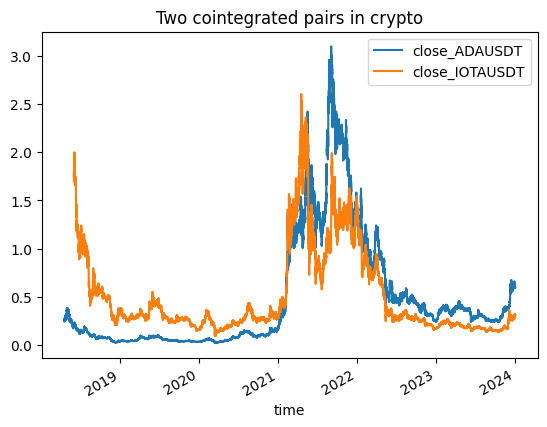

In [5]:
df_close.plot(
    x="time", 
    y=["close_ADAUSDT", "close_IOTAUSDT"], 
    title="Two cointegrated pairs in crypto"
)

plt.show()

<h4>Cointegration</h4>
<p>The idea is as follows: if we have two time series generating processes: </p>

$y_{1t} = x_{t} + w_{1t}$ \
$y_{2t} = x_t + w_{2t}$

<p>We sample our two potentially cointegrated time series from them. If such time series are integrated of order 1, meaning that by taking first-differences we will obtain stationary series, then if there exists any linear combination of these time series such that this linear combination is stationary, then these time series are cointegrated. Let's have a look at the following example:</p>

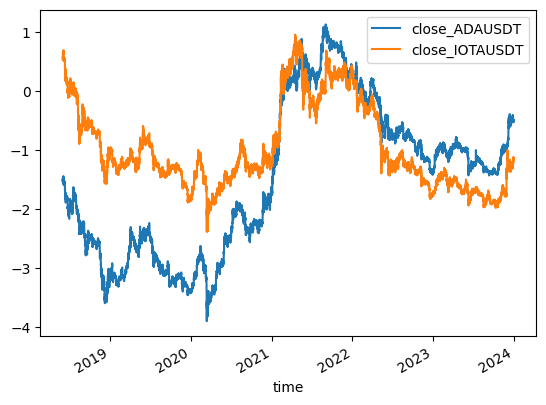

In [6]:
# find log prices and check if ADAUSDT, IOTAUSDT pair is cointegrated using Engle–Granger two-step method
data = df_close[
    (df_close["close_ADAUSDT"].notna()) & 
    (df_close["close_IOTAUSDT"].notna())
][["time", "close_ADAUSDT", "close_IOTAUSDT"]].copy()


data["close_ADAUSDT"] = data["close_ADAUSDT"].apply(np.log)
data["close_IOTAUSDT"] = data["close_IOTAUSDT"].apply(np.log)

data.plot(x="time", y=["close_ADAUSDT", "close_IOTAUSDT"])
plt.show()

In [7]:
from statsmodels.tsa.stattools import coint

# The Null hypothesis is that there is no cointegration, the alternative hypothesis is that there is cointegrating relationship
pvalue = coint(data["close_ADAUSDT"], data["close_IOTAUSDT"])[1]
pvalue

0.7700624889290916

In [8]:
# apply Engle–Granger two-step method
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

X = data["close_ADAUSDT"].values
X = add_constant(X)

Y = data["close_IOTAUSDT"].values

model = OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                 3.325e+04
Date:                Sun, 21 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:29:20   Log-Likelihood:                -42475.
No. Observations:               51110   AIC:                         8.495e+04
Df Residuals:                   51108   BIC:                         8.497e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4463      0.004   -121.592      0.0

In [9]:
from statsmodels.tsa.stattools import adfuller

pvalue = adfuller(model.resid)[1]
pvalue

0.06458801682600909

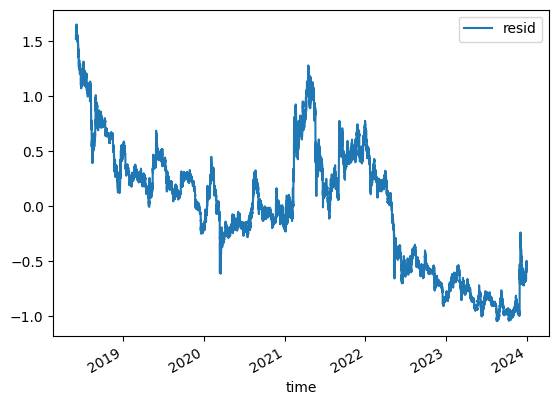

In [10]:
df_resid = pd.DataFrame({
    "time": data["time"],
    "resid": model.resid
})

df_resid.plot(x="time", y="resid")
plt.show()

<p>Algorithmically find potentially cointegrated pairs</p>

In [11]:
def run_cointegration_test(df_roll: pd.DataFrame, first_ticker: str, second_ticker: str) -> float:
    """apply Engle–Granger two-step method to check cointegration"""

    X = df_roll[f"close_{first_ticker}"]
    X = add_constant(X)

    Y = df_roll[f"close_{second_ticker}"]
    
    model = OLS(Y, X).fit()
    pvalue = adfuller(model.resid)[1]

    return pvalue

In [12]:
def find_cointegration(
        df_close: pd.DataFrame, first_ticker: str, second_ticker: str, pval_tol: float
) -> pd.DataFrame:
    
    # leave only rows when both tickers existed
    df_close = df_close[
        (df_close[f"close_{first_ticker}"].notna()) &
        (df_close[f"close_{second_ticker}"].notna())
    ].copy()

    df_close[f"close_{first_ticker}"] = df_close[f"close_{first_ticker}"].apply(np.log)
    df_close[f"close_{second_ticker}"] = df_close[f"close_{second_ticker}"].apply(np.log)

    window_size = 24*180 # window size of essentially one month
    overlap = 24*60 # with overlap of half a week

    signals = []

    num_iterations = (df_close.shape[0] - window_size) // overlap + 1
    pbar = tqdm(range(num_iterations), desc="Generating Windows", leave=False)

    for i in pbar:

        start = i * overlap
        end = start + window_size
        df_roll = df_close.iloc[start:end]

        pval: float = run_cointegration_test(
            df_roll=df_roll, first_ticker=first_ticker, second_ticker=second_ticker
        )
        
        if pval <= pval_tol:
            signals.append({
                "start_coint": df_roll["time"].iloc[0],
                "end_coint": df_roll["time"].iloc[-1],
                "pval": pval
            })

        i += overlap
        
    return pd.DataFrame(signals)

In [13]:
first_ticker, second_ticker = "DNTUSDT", "WANUSDT"

signals = find_cointegration(
    df_close=df_close,
    first_ticker=first_ticker,
    second_ticker=second_ticker,
    pval_tol=0.001
)

In [14]:
signals = signals.sort_values(by="pval")
signals.head()

,start_coint,end_coint,pval
1,2022-04-02 05:59:59.999,2022-09-29 04:59:59.999,1.896801e-13
0,2021-03-10 15:59:59.999,2021-09-07 01:59:59.999,6.174439e-04


<p>As we can see the procedure works we are able to find all cointegrated windows with very low pvalues of cointegration test. But we will have to perform a lot of tests, therefore despite having a very low p-value, we are almost guaranteed to get some false positives in the final result, as we have to perform the test multiple times.</p>

In [15]:
train = df_close[
    (df_close["time"] >= signals["start_coint"].iloc[0]) & 
    (df_close["time"] <= signals["end_coint"].iloc[0])
][["time", f"close_{first_ticker}", f"close_{second_ticker}"]]

train = train.dropna()

X_train = train[f"close_{first_ticker}"].apply(np.log)
X_train = add_constant(X_train)

Y_train = train[f"close_{second_ticker}"].apply(np.log)

model = OLS(Y_train, X_train).fit()
mu, gamma = model.params

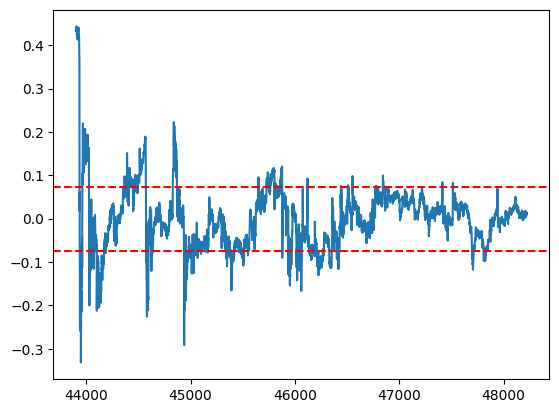

In [16]:
model.resid.plot()

lb = model.resid.mean() - model.resid.std()
ub = model.resid.mean() + model.resid.std()

plt.axhline(y=lb, color="red", linestyle="--")
plt.axhline(y=ub, color="red", linestyle="--")
plt.show()

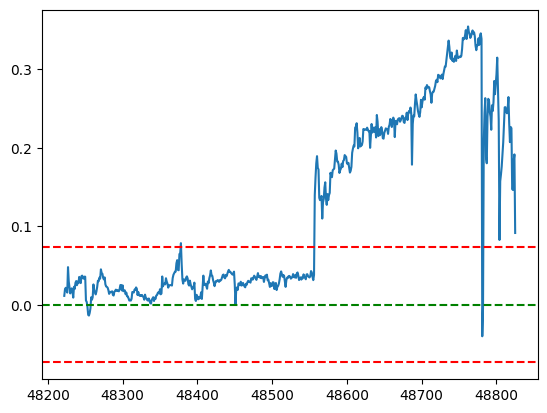

In [17]:
test = df_close[
    (df_close["time"] > signals["end_coint"].iloc[0]) &
    (df_close["time"] <= signals["end_coint"].iloc[0] + pd.Timedelta(days=30))
]

X_test = test[f"close_{first_ticker}"].apply(np.log)
Y_test = test[f"close_{second_ticker}"].apply(np.log)

plt.plot(
    Y_test - gamma * X_test - mu
)

plt.axhline(y=lb, color="red", linestyle="--")
plt.axhline(y=ub, color="red", linestyle="--")
plt.axhline(y=0, color="green", linestyle="--")

plt.show()

<h4>Find cointegrated pairs on test set and trade their spread</h4>

<p>In order to find all cointegrated pairs, I created a script which I ran on my laptop for 2 hours. It checked all pair combinations of top-100 cryptos from 2017 to 2024. I had to use multiprocessing to make it finish in reasonable time otherwise it would have taken closer to 24 hours to complete. Results are stored in data/signals folder inside of the root project directory.</p>
<p>The pipeline to find cointegration is the same as shown in the notebook: run a rolling window of 180 days over all the time two pairs existed and run a regression on their log prices, then check if the residuals from this regression are stationary using ADF test. In order to ensure we get the least false positives due to multiple hypothesis test bias, I set a target p-value of 1e-10.</p>

In [18]:
# load cointegration data from ROOT_DIR/data/signals
coint_signals_dir = os.path.join(ROOT_DIR, "data/signals")

df_coint = pd.DataFrame()

for file in os.listdir(coint_signals_dir):
    df_tmp = pd.read_csv(os.path.join(coint_signals_dir, file))
    df_coint = pd.concat([df_coint, df_tmp], axis=0)

df_coint["start_coint"] = pd.to_datetime(df_coint["start_coint"])
df_coint["end_coint"] = pd.to_datetime(df_coint["end_coint"])

df_coint.head(2)

,pair,start_coint,end_coint,pval
0,ACAUSDT-LUNAUSDT,2022-03-07 09:59:59.999,2022-07-09 17:59:59.999,2.885709e-09
1,ACAUSDT-LUNAUSDT,2022-03-22 09:59:59.999,2022-09-07 17:59:59.999,6.281622e-09


In [19]:
# remove all luna cases, after UST collapse it was temporarily delisted before rebrending to LUNC
# this produced a huge gap in the data
df_coint = df_coint[
    ~df_coint["pair"].str.contains("LUNA") &
    ~df_coint["pair"].str.contains("PAX")
]
df_coint.shape

(1211, 4)

In [20]:
# some pairs are classified as cointegrated multiple times like a 60 days passed and they are still cointegrated
len(df_coint["pair"].unique())

1071

<p>Split found cointegrations into train and test samples, we will use train sample to find optimal parameters to get the most profit from spreads, then we will backtest the rest of cointegrations from the test set using found parameters</p> 

In [21]:
train_ts = pd.Timestamp("2023-01-01 0:00:00")

df_train = df_coint[df_coint["end_coint"] <= train_ts].copy()
df_test = df_coint[df_coint["start_coint"] > train_ts].copy()

df_train.shape, df_test.shape

((745, 4), (304, 4))

In [22]:
def fit_OLS(
    df_close: pd.DataFrame, pair: str, start_coint: pd.Timestamp, end_coint: pd.Timestamp
):
    first_ticker, second_ticker = pair.split("-")

    data = df_close[["time", f"close_{first_ticker}", f"close_{second_ticker}"]].copy()
    data = data[data["time"].between(start_coint, end_coint)]

    tickers = [f"close_{first_ticker}", f"close_{second_ticker}"]
    data[tickers] = data[tickers].apply(np.log)
    
    data = data.dropna()

    X = data[f"close_{first_ticker}"]
    X = add_constant(X)

    Y = data[f"close_{second_ticker}"]

    model = OLS(Y, X).fit()

    df_res = pd.DataFrame({
        "time": data["time"],
        "resid": model.resid,
    })

    return model, df_res

In [23]:
def backtest_coint(
    df_close: pd.DataFrame, model, pair: str, end_coint: pd.Timestamp, n_days: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    mu, gamma = model.params
    first_ticker, second_ticker = pair.split("-")

    ticker_cols = [f"close_{first_ticker}", f"close_{second_ticker}"]

    df_test = df_close[
        (df_close["time"] > end_coint) &
        (df_close["time"] <= end_coint + pd.Timedelta(days=n_days))
    ][["time"] + ticker_cols].copy()

    df_test[ticker_cols] = df_test[ticker_cols].apply(np.log)
    df_test = df_test.dropna()

    X = df_test[f"close_{first_ticker}"]
    Y = df_test[f"close_{second_ticker}"]

    df_res = pd.DataFrame({
        "time": df_test["time"],
        "resid": Y - gamma*X - mu
    })

    return (df_res, df_test)

In [24]:
from dataclasses import dataclass

@dataclass
class Limit:
    lb: float
    ub: float
    take: float
    stop_long: float
    stop_short: float


def create_thresholds(df_res: pd.DataFrame) -> Limit:
    df_res_clean = df_res[
        (df_res["resid"] >= df_res["resid"].quantile(.025)) &
        (df_res["resid"] <= df_res["resid"].quantile(.975))
    ].copy()

    take = df_res_clean["resid"].mean()
    lb = take - 2*df_res_clean["resid"].std()
    ub = take + 2*df_res_clean["resid"].std()
    stop_long = take - 3*df_res_clean["resid"].std()
    stop_short = take + 3*df_res_clean["resid"].std()

    return Limit(
        lb=lb, ub=ub, take=take, 
        stop_long=stop_long, 
        stop_short=stop_short
    )

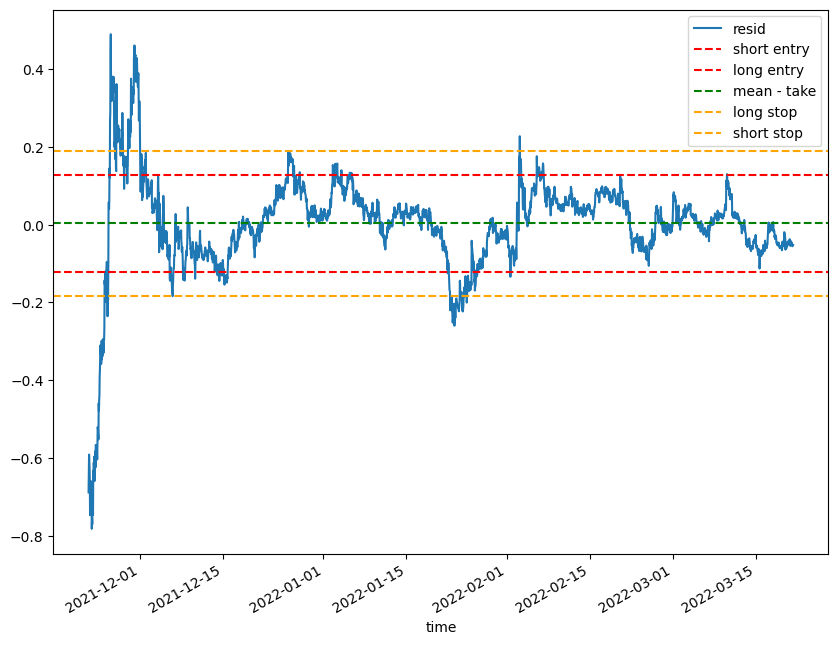

In [25]:
idx = 147

model, df_res = fit_OLS(
    df_close=df_close, 
    pair=df_train["pair"].iloc[idx], 
    start_coint=df_train["start_coint"].iloc[idx],
    end_coint=df_train["end_coint"].iloc[idx]
)

df_res.plot(x="time", y="resid", figsize=(10, 8))

limit: Limit = create_thresholds(df_res=df_res)

plt.axhline(y=limit.ub, color="red", linestyle="--", label="short entry")
plt.axhline(y=limit.lb, color="red", linestyle="--", label="long entry")
plt.axhline(y=limit.take, color="green", linestyle="--", label="mean - take")
plt.axhline(y=limit.stop_long, color="orange", linestyle="--", label="long stop")
plt.axhline(y=limit.stop_short, color="orange", linestyle="--", label="short stop")

plt.legend()

plt.show()

In [26]:
def create_signals(
        df_res: pd.DataFrame, 
        limit: Limit
) -> pd.DataFrame:
    
    df_res["resid_prev"] = df_res["resid"].shift(1)
    # create signals to long short spread
    df_res["action"] = None

    long_condition = (df_res["resid_prev"] >= limit.lb) & (df_res["resid"] <= limit.lb)
    short_contition = (df_res["resid_prev"] <= limit.ub) & (df_res["resid"] >= limit.ub)
    # define take profit conditions - where spread mean reverts to 0
    long_take_profit = (df_res["resid_prev"] <= limit.take) & (df_res["resid"] >= limit.take)
    short_take_profit = (df_res["resid_prev"] >= limit.take) & (df_res["resid"] <= limit.take)

    # define stop losses
    long_stop_loss = (df_res["resid_prev"] >= limit.stop_long) & (df_res["resid"] <= limit.stop_long)
    short_stop_loss = (df_res["resid_prev"] <= limit.stop_short) & (df_res["resid"] >= limit.stop_short)

    df_res.loc[long_condition, "action"] = "long"
    df_res.loc[short_contition, "action"] = "short"
    df_res.loc[long_take_profit, "action"] = "long_take"
    df_res.loc[short_take_profit, "action"] = "short_take"
    df_res.loc[long_stop_loss, "action"] = "long_stop"
    df_res.loc[short_stop_loss, "action"] = "short_stop"

    df_signals =  df_res[df_res["action"].notna()]
    
    return df_signals

In [27]:
# plot spread over the next 30 days after being labelled as cointegrated
df_res, df_o = backtest_coint(
    df_close=df_close,
    model=model,
    pair=df_train["pair"].iloc[idx], 
    end_coint=df_train["end_coint"].iloc[idx],
    n_days=30 # how far in time to backtest 
)

df_signals = create_signals(
    df_res=df_res, limit=limit
)
df_signals.head()

,time,resid,resid_prev,action
43197,2022-03-24 23:59:59.999,0.017385,-0.011415,long_take
43205,2022-03-25 01:59:59.999,-0.008874,0.006952,short_take
43389,2022-03-26 23:59:59.999,0.011359,-0.003456,long_take
43441,2022-03-27 12:59:59.999,-0.028435,0.008333,short_take
43481,2022-03-27 22:59:59.999,0.033127,-0.008088,long_take


In [28]:
transaciton_cost = 0.001

def calculate_profit(df_signals: pd.DataFrame):
    position_direction, entry_spread = None, None

    history: List[Dict[str, Any]] = []

    for _, signal in df_signals.iterrows():

        if signal.action == "long":
            # there are duplicate position do not open if there is already one opened
            if not position_direction:
                position_direction, entry_spread= "long", signal["resid"]
                history.append({
                    "time": signal.time,
                    "action": signal.action,
                    "profit": -transaciton_cost
                })
        elif signal.action == "short":
            if not position_direction:
                position_direction, entry_spread = "short", signal["resid"]
                history.append({
                    "time": signal.time,
                    "action": signal.action,
                    "profit": -transaciton_cost
                })

        # if we do not have any open position then skip
        if not position_direction:
            continue

        # once there is an opened position
        if signal.action == "long_take" and position_direction == "long":
            # execute long take profit
            history.append({
                "time": signal.time,
                "action": signal.action,
                "profit": signal["resid"] - entry_spread - transaciton_cost
            })
            position_direction, entry_spread = None, None # close position and reset entry

        elif signal.action == "short_take" and position_direction == "short":
            history.append({
                "time": signal.time,
                "action": signal.action,
                "profit": entry_spread - signal["resid"] - transaciton_cost
            })
            position_direction, entry_spread = None, None # close position and reset entry

        elif signal.action == "long_stop" and position_direction == "long":
            history.append({
                "time": signal.time,
                "action": signal.action,
                "profit": signal["resid"] - entry_spread - transaciton_cost
            })
            position_direction, entry_spread = None, None # close position and reset entry

        elif signal.action == "short_stop" and position_direction == "short":
            history.append({
                "time": signal.time,
                "action": signal.action,
                "profit": entry_spread - signal["resid"] - transaciton_cost
            })
            position_direction, entry_spread = None, None # close position and reset entry

    return pd.DataFrame(history)

In [29]:
df_profit = calculate_profit(df_signals)
df_profit

,time,action,profit
0,2022-03-30 15:59:59.999,short,-0.001000
1,2022-03-31 22:59:59.999,short_stop,-0.068619
2,2022-04-06 01:59:59.999,short,-0.001000


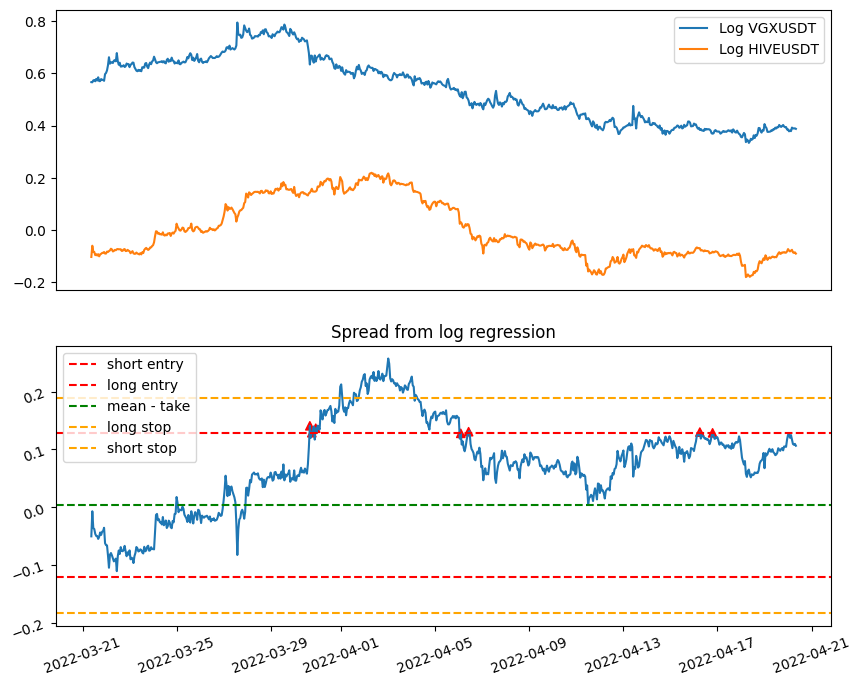

In [30]:
first_ticker, second_ticker = df_train["pair"].iloc[idx].split("-")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(df_o.time, df_o[f"close_{first_ticker}"], label=f"Log {first_ticker}")
ax1.plot(df_o.time, df_o[f"close_{second_ticker}"], label=f"Log {second_ticker}")
ax1.legend()

ax1.set_xticks([])

ax2.plot(df_res.time, df_res.resid)
ax2.set_title("Spread from log regression")

ax2.axhline(y=limit.ub, color="red", linestyle="--", label="short entry")
ax2.axhline(y=limit.lb, color="red", linestyle="--", label="long entry")
ax2.axhline(y=limit.take, color="green", linestyle="--", label="mean - take")
ax2.axhline(y=limit.stop_long, color="orange", linestyle="--", label="long stop")
ax2.axhline(y=limit.stop_short, color="orange", linestyle="--", label="short stop")
ax2.legend()

long_short_signals = df_signals[
    df_signals["action"].isin(["long", "short"])
]

colors =  long_short_signals["action"].map({
    "long": "green", 
    "short": "red"
})

ax2.scatter(
    long_short_signals["time"], long_short_signals["resid"], c=colors, marker="^"
)

ax2.tick_params(labelrotation=20)

plt.show()

<h4>Find profit on train and test sets without any tuning as is</h4>

In [31]:
def calculate_stats(
    pair: str, start_coint: pd.Timestamp, end_coint: pd.Timestamp, n_days: int
):
    
    model, df_res = fit_OLS(
        df_close=df_close, 
        pair=pair, 
        start_coint=start_coint,
        end_coint=end_coint
    )

    limit: Limit = create_thresholds(df_res=df_res)

    df_res, _ = backtest_coint(
        df_close=df_close,
        model=model,
        pair=pair, 
        end_coint=end_coint,
        n_days=n_days # how far in time to backtest 
    )

    df_signals = create_signals(
        df_res=df_res, limit=limit
    )

    df_profit = calculate_profit(df_signals=df_signals)
    
    if df_profit.empty:
        return 
    
    df_profit["pair"] = pair
    
    return df_profit

In [32]:
def pool_stats(df: pd.DataFrame, n_days: int): 
    df_stats = pd.DataFrame()
    for _, row in tqdm(df.iterrows(), total=df.shape[0], leave=False):
        df_profit = calculate_stats(
            pair=row["pair"], start_coint=row["start_coint"], end_coint=row["end_coint"], n_days=n_days
        )
        df_stats = pd.concat([df_stats, df_profit], axis=0)
    return df_stats

In [33]:
df_stats = pool_stats(df_coint, n_days=15)

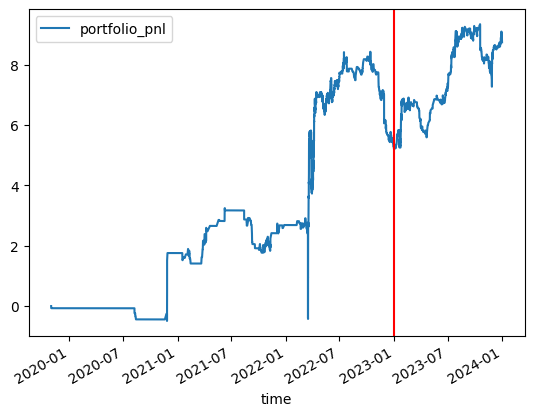

In [34]:
df_stats = df_stats.sort_values(by="time", ascending=True)
df_stats["portfolio_pnl"] = df_stats["profit"].cumsum()

df_stats.plot(x="time", y="portfolio_pnl")
plt.axvline(x=train_ts, color="red")

plt.show()

<p>There is no difference between train and test sample, since all pairs are estimated on cointegrated part and then their performance is evaluated over a period of 15 days after 180 days.</p>

<h4>Sharpe ratio</h4>

In [35]:
annual_returns = df_stats.resample("1Y", on="time")["profit"].sum()

sharpe = (annual_returns.mean() - 0.03) / annual_returns.std()
sharpe

1.2332371532998043

<p>Finally, I believe that it is possible to further develop this approach and make something out of it given enough time and effort put into this. One might apply different approaches to finding cointegrated pairs. Also this is the simplest realization of the strategy as I don't update the coefficients of linear regression as time goes by, here I could have implemented somethign like Kalman filter to achieve this updating. It turned out that one week is very little time to do something like this)). I would change a lot in this work. To start off, I think it is better to find cointegratation based on something, maybe I would have started with cluster analysis of tickers based on their returns and descriptions from CMC, maybe by doing this I would have been able to reduce the search space substantially. Also cointegration exists as a linear combination not neccessarily of two time series but multiple, I could have also investigated this path.</p>